# Comparison and validation of the AlphaMissense predictor
### for sarcomeric gene variants in coding regions

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve
import os
import re
import plotly.graph_objects as go
from stats import *
if('analysis' in os.getcwd()):
    os.chdir('../')
else:
    print(os.getcwd())

In [2]:
datatypes = {'POS': 'int64',
             'REF': 'str',
             'ALT': 'str'}
# alpha missense data
ams_prediction = pd.read_csv('_in/sarcomeric_annotated_ams.csv',header=0, dtype=datatypes)

# VEP annotation data (other predictors)
vep_prediction = pd.read_csv('VEP_format/vep_results/vep_prediction_scores.csv',
                             header = 0, sep = ',', dtype=datatypes,na_values="-")

## About the variants

1. Own classification according to the ACMG criteria
- Class 0 = benign LB/B
- Class 1 = pathogenic LP/P
- Class 0.5 = VUS/VUS+ (Variants of Uncertain Significance)
2. Where these variants come from?
From Health in Code
3. How are they classified?
According many criteria, specifically:
- Low frequency in controls (gnomAD allele frequency)
- High number (proportion) of having the disease in the HiC cohort --> ask Juan Pablo
1. ¿What disease are we studying?
- Hyperthrophic cardiomyopathy

In [3]:
ams_prediction.head()

,CHROM,POS,REF,ALT,Class,Freq,Gene,genome,uniprot_id,transcript_id,protein_variant,am_pathogenicity,am_class
0,1,201359214,T,C,0.5,0,TNNT2,hg38,P45379,ENST00000656932.1,K298R,0.3310,likely_benign
1,1,201359220,C,T,1.0,<0.01,TNNT2,hg38,P45379,ENST00000656932.1,R296H,0.7750,likely_pathogenic
2,1,201359221,G,A,1.0,<0.01,TNNT2,hg38,P45379,ENST00000656932.1,R296C,0.9289,likely_pathogenic
3,1,201359221,G,T,0.5,0,TNNT2,hg38,P45379,ENST00000656932.1,R296S,0.9826,likely_pathogenic
4,1,201359223,C,T,0.5,0,TNNT2,hg38,P45379,ENST00000656932.1,G295E,0.9891,likely_pathogenic


In [4]:
ams_prediction.Gene.unique()

array(['TNNT2', 'MYBPC3', 'MYH7', 'ACTC1', 'TPM1', 'TNNI3', 'TNNC1'],
      dtype=object)

In [5]:
n = len(ams_prediction)
benign = sum(ams_prediction['Class'] == 0)
patog = sum(ams_prediction['Class'] == 1)
vus = sum(ams_prediction['Class'] == 0.5)
print(f"Total: {n}\nBenign: {benign}\nPathogenic: {patog}\nVUS: {vus}")

Total: 1973
Benign: 112
Pathogenic: 434
VUS: 1427


Filtramos variantes VUS

## Procedure

### Dataframe union/join
Left joint to have all (labels + AMS + other predictors) in a single dataframe

In [6]:
merged = pd.merge(ams_prediction,vep_prediction, on = ['CHROM','POS','ALT'], how='left')
merged.head()
# merged.to_csv('analysis/R_figures/data.csv')

,CHROM,POS,REF,ALT,Class,Freq,Gene,genome,uniprot_id,transcript_id,...,Polyphen2_HDIV_score,Polyphen2_HVAR_score,REVEL_score,SIFT4G_score,SIFT_score,DANN_score,MetaLR_score,MetaRNN_score,PrimateAI_score,gnomADv4_AF
0,1,201359214,T,C,0.5,0,TNNT2,hg38,P45379,ENST00000656932.1,...,NaN,NaN,0.051,0.000,0.334,0.997218,0.0347,0.226106,0.690024,NaN
1,1,201359220,C,T,1.0,<0.01,TNNT2,hg38,P45379,ENST00000656932.1,...,NaN,NaN,0.552,0.010,0.000,0.999529,0.1184,0.148572,0.704665,0.000046
2,1,201359221,G,A,1.0,<0.01,TNNT2,hg38,P45379,ENST00000656932.1,...,NaN,NaN,0.471,0.059,0.005,0.999210,0.1092,0.786186,0.757542,0.000007
3,1,201359221,G,T,0.5,0,TNNT2,hg38,P45379,ENST00000656932.1,...,NaN,NaN,0.211,0.037,0.033,0.994888,0.0717,0.454849,0.692415,NaN
4,1,201359223,C,T,0.5,0,TNNT2,hg38,P45379,ENST00000656932.1,...,NaN,NaN,0.265,0.017,0.001,0.997422,0.1414,0.506293,0.815157,NaN


In [7]:
merged.describe(percentiles=None)

,CHROM,POS,Class,am_pathogenicity,MAX_AF,gnomAD_exomes_AF,gnomADe_AF,CADD_phred,CADD_RAW,FATHMM_score,...,Polyphen2_HDIV_score,Polyphen2_HVAR_score,REVEL_score,SIFT4G_score,SIFT_score,DANN_score,MetaLR_score,MetaRNN_score,PrimateAI_score,gnomADv4_AF
count,1973.000000,1.973000e+03,1973.000000,1949.000000,928.000000,725.000000,927.000000,1951.000000,1937.000000,1946.000000,...,1116.000000,1116.000000,1946.000000,1949.000000,1886.000000,1951.000000,1949.000000,1949.000000,1894.000000,644.000000
mean,12.078561,4.901362e+07,0.581602,0.524700,0.000864,0.000114,0.000526,24.297453,3.296701,-1.536948,...,0.670517,0.635119,0.576416,0.129307,0.093061,0.972003,0.580518,0.685251,0.666357,0.000164
std,3.562455,3.841289e+07,0.250114,0.318088,0.009272,0.001749,0.005639,5.638779,1.079212,1.715018,...,0.405820,0.388056,0.275215,0.225025,0.207861,0.099784,0.290603,0.304506,0.162619,0.002424
min,1.000000,2.341286e+07,0.000000,0.046300,0.000000,0.000004,0.000000,0.001000,-1.601913,-7.730000,...,0.000000,0.000000,0.008000,0.000000,0.000000,0.060980,0.000600,0.001683,0.222981,0.000007
25%,11.000000,2.342904e+07,0.500000,0.221100,0.000009,0.000008,0.000008,23.000000,2.761488,-2.767500,...,0.217000,0.216000,0.354500,0.002000,0.001000,0.992867,0.341000,0.467621,0.556612,0.000007
50%,11.000000,4.733742e+07,0.500000,0.475000,0.000033,0.000016,0.000016,25.000000,3.590156,-1.350000,...,0.934000,0.818500,0.621000,0.026000,0.005000,0.997755,0.630700,0.828975,0.690334,0.000020
75%,14.000000,4.734990e+07,0.500000,0.861200,0.000065,0.000037,0.000048,27.500000,4.064012,-0.230000,...,0.999000,0.993000,0.821750,0.150000,0.063000,0.998957,0.838300,0.922959,0.796440,0.000039
max,19.000000,2.013732e+08,1.000000,0.999900,0.153500,0.046963,0.096430,35.000000,6.325529,2.930000,...,1.000000,1.000000,0.984000,1.000000,1.000000,0.999609,0.998200,0.994189,0.943854,0.061277


### Exploratory data analysis

#### AlphaMissense

In [8]:
ams_cols = ['CHROM','POS','REF','ALT','am_pathogenicity','am_class']
ams_prediction.loc[:,ams_cols].head()

,CHROM,POS,REF,ALT,am_pathogenicity,am_class
0,1,201359214,T,C,0.3310,likely_benign
1,1,201359220,C,T,0.7750,likely_pathogenic
2,1,201359221,G,A,0.9289,likely_pathogenic
3,1,201359221,G,T,0.9826,likely_pathogenic
4,1,201359223,C,T,0.9891,likely_pathogenic


In [9]:
set(ams_prediction['am_class'])

{'ambiguous', 'likely_benign', 'likely_pathogenic', nan}

##### Variants not classified by AMS

In [10]:
print(f"There are {len(merged)} variants in total, of which: \n")
miss = merged['am_class'].isna()
ams_miss = merged[miss]
print(f"{sum(miss)} variants not classified by AMS:\n")
ams_miss.loc[:,ams_cols].head()
ams_miss2 = ams_miss.groupby('Gene')['Gene'].count()
print(f"In the following genes {ams_miss2}")

There are 1973 variants in total, of which: 

24 variants not classified by AMS:

In the following genes Gene
MYBPC3     1
MYH7       1
TPM1      22
Name: Gene, dtype: int64


##### Variantes classified by AMS

How many variants and what are they average score.

Cuántas variantes y qué puntuación promedio otorga AlphaMissense a las variantes estudiadas

In [11]:
grouped_by_amclass = merged.groupby('am_class')
grouped_by_amclass['am_class'].count()
grouped_by_amclass.agg(Total=('am_class', 'count'),
                       Average = ('am_pathogenicity','mean'),
                       Max = ('am_pathogenicity','max'),
                       Min = ('am_pathogenicity','min'))

,Total,Average,Max,Min
am_class,,,,
ambiguous,341,0.448398,0.5639,0.3404
likely_benign,761,0.193808,0.3392,0.0463
likely_pathogenic,847,0.852714,0.9999,0.5643


##### Confussion Matrix (AMS)

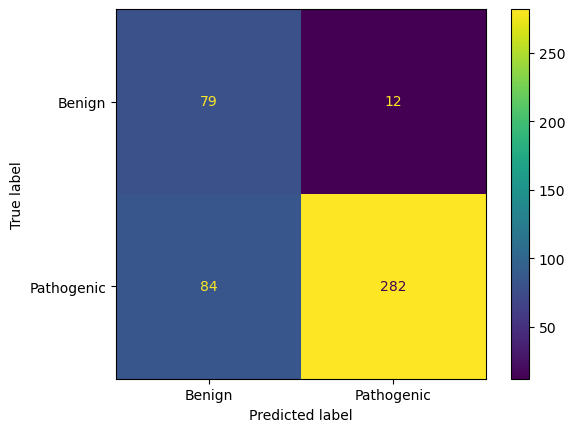

In [12]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
x = merged.loc[:,['Class','am_class']].copy()
x['am_class'] = np.where(x['am_class'] == 'likely_benign',0,np.where(x['am_class'] == 'likely_pathogenic',1,0.5))
x = x[(x['am_class'] != 0.5) & (x['Class'] != 0.5)]
x.dropna(inplace=True)
cm = confusion_matrix(x['Class'],x['am_class'])
ConfusionMatrixDisplay(cm,display_labels=['Benign','Pathogenic']).plot()
plt.savefig('analysis/out/ams_cm.png',bbox_inches='tight')

##### Sensibility and specificity

Excluding VUS variants

Calculamos sensibilidad y especificidad (eliminando las ambiguas)

- Sensibilidad: capacidad de la herramienta de distinguir verdaderos positivos de entre todos los positivos (% de positivos que son realmente positivos)
- Especificidad: capacidad de la herramienta de distinguir verdaderos negativos (% de negativos que son realmente negativos)

Es decir, todo lo que no es un true_pos o true_neg pasa a ser un falso negativo o falso positivo.

sensibilidad = verdaderos patogénicos (1 & likely patogenic)

especificidad = verdaderos no patogénicos (0 & likely benign)

In [13]:
from stats import *
val = merged['Class'].copy()
pred = merged['am_class'].copy()
sens = sensitivity(val,pred)
spec = specificity(val,pred)
print(f"Sensitivity, AlphaMissense:\n{round(sens,2)}")
print(f"Specificity, AlphaMissense:\n{round(spec,2)}")

79
Sensitivity, AlphaMissense:
0.87
Specificity, AlphaMissense:
0.77


#### CADD

CADD es una herramienta de puntuación de SPNs y INDELS según su potencial de ser deletéreas basándose en múltiples métricas.

Utiliza el CADD_phred, una variable contínua de 1 a 99 (formato phred). [Un punto de corte establecido es 20](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6386394/.)


In [14]:
merged['CADD_phred'].describe()

count    1951.000000
mean       24.297453
std         5.638779
min         0.001000
25%        23.000000
50%        25.000000
75%        27.500000
max        35.000000
Name: CADD_phred, dtype: float64

##### Empty values

In [15]:
n = len(merged[merged['CADD_phred'].isna()])
print(n)

22


#### Sensitivity and specificity

Clasificamos las variantes como patogénicas o benignas según la puntuación de CADD_PHRED.
Calculamos su sensibilidad y especificidad.

In [16]:
merged['CADD_pred'] = np.where(merged['CADD_phred'] >= 20,'likely_pathogenic','likely_benign') # new column

val = merged['Class'].copy()
pred = merged['CADD_pred'].copy()
sens = sensitivity(val,pred)
spec = specificity(val,pred)
print(f"Sensitivity, CADD:\n{round(sens,2)}")
print(f"Specificity, CADD:\n{round(spec,2)}")

35
Sensitivity, CADD:
0.31
Specificity, CADD:
0.97


#### REVEL

For predicting the deleteriousness of each nucleotide change in the genome. 

For example, 75.4% of disease mutations but only 10.9% of neutral variants (and 12.4% of all ESVs) have a REVEL score above 0.5, corresponding to a sensitivity of 0.754 and specificity of 0.891. Selecting a more stringent REVEL score threshold of 0.75 would result in higher specificity but lower sensitivity, with 52.1% of disease mutations, 3.3% of neutral variants, and 4.1% of all ESVs being classified as pathogenic". (Figure S1 of the reference below) 

In [17]:
n = len(merged[merged['REVEL_score'].isna()])
print(n)

27


In [18]:
merged['REVEL_pred'] = np.where(merged['REVEL_score'] > 0.75,'likely_pathogenic','likely_benign') # new column

val = merged['Class'].copy()
pred = merged['REVEL_pred'].copy()
sens = sensitivity(val,pred)
spec = specificity(val,pred)
print(f"Sensitivity, REVEL:\n{round(sens,2)}")
print(f"Specificity, REVEL:\n{round(spec,2)}")

105
Sensitivity, REVEL:
0.94
Specificity, REVEL:
0.62


## ROC curve

Curva y area bajo la curva de todos los predictores

- **AlphaMissense**
- **CADD**
- **REVEL**
- PolyPhen2
- MutationTaster
- MutPred
- SIFT4G
- FATHMM

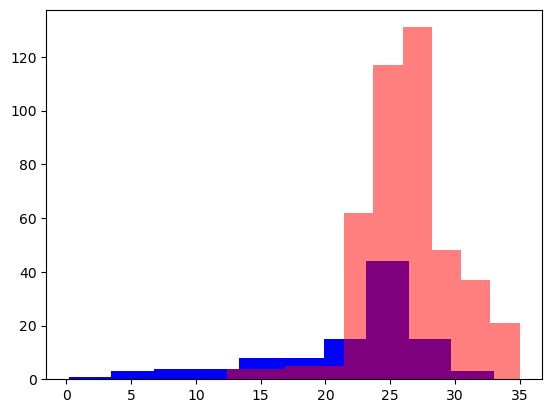

In [19]:
# merged['CADD_phred'].hist(range = [0,99])
good = merged['CADD_phred'].where(merged['Class'] == 0.0)
bad = merged['CADD_phred'].where(merged['Class'] == 1)
plt.hist(good,color = 'blue')
plt.hist(bad,color='red',alpha = 0.5)
plt.show()

In [20]:
merged['Class'].unique()

array([0.5, 1. , 0. ])

<Axes: >

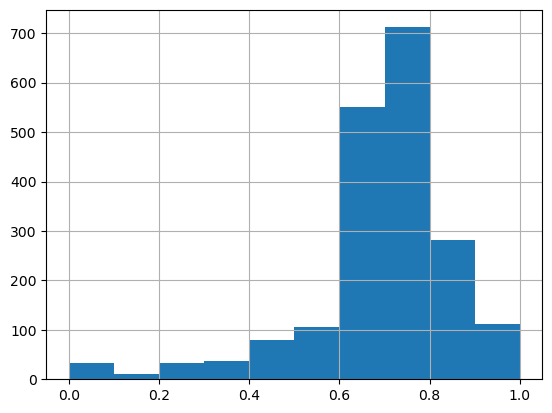

In [21]:
# Change CADD scale to be in the 0-1 range
from sklearn import preprocessing

scaler = preprocessing.MinMaxScaler()
# a = np.array(range(1,37)).reshape(-1,1)
# scaler.fit(a)
merged['CADD_scaled'] = scaler.fit_transform(merged['CADD_phred'].to_numpy().reshape(-1,1))
merged['CADD_scaled'].hist()

In [22]:
# merged['CADD_scaled'] = 1 - 10**((-merged['CADD_phred'])/10)
# merged['CADD_scaled'].hist()

In [23]:
from math import *
scaler = preprocessing.MinMaxScaler()
merged['FATHMM_scaled'] = scaler.fit_transform(merged['FATHMM_score'].to_numpy().reshape(-1,1))
merged['FATHMM_scaled'].describe()

count    1946.000000
mean        0.580962
std         0.160883
min         0.000000
25%         0.465525
50%         0.598499
75%         0.703565
max         1.000000
Name: FATHMM_scaled, dtype: float64

In [24]:
roc_df = merged[merged['Class'] != 0.5] # remove variants non labeled as 0 (B/LB) or 1 (P/LP)

#### Using the same variants

Escogeremos solamente aquellas variantes que tengan puntuaciones en todos los predictores para evitar sesgos.


In [25]:
predictors = ['am_pathogenicity','CADD_scaled','REVEL_score','Polyphen2_HVAR_score','MutationTaster_score','MutPred_score',
              'SIFT4G_score','FATHMM_scaled','DANN_score','MetaLR_score','MetaRNN_score','PrimateAI_score']
pred = ['Class'] + predictors
# roc_df = merged
roc_data = roc_df[~roc_df.loc[:,pred].isnull().any(axis=1)].loc[:,pred]
roc_data.shape


(281, 13)

#### Using different variants

In [26]:
def get_non_missing_data(data: pd.DataFrame,col2,col1 = 'Class'):
    '''Devuelve un dataframe con los valores a usar en la curva ROC
    y los corrige, si necesario.
    FIX: realmente es un código repetido, solo es necesario llamar a isnull.any 1 vez
    '''
    s_data =  data[~data.loc[:,[col1,col2]].isnull().any(axis=1)].loc[:,[col1,col2]]
    if col2 in ['SIFT4G_score','FATHMM_scaled']:
        s_data[col2] = 1 - s_data[col2]
        print(col2)
    # print(s_data.shape)
    return s_data

roc_data = {x:get_non_missing_data(roc_df,x) for x in predictors}

SIFT4G_score
FATHMM_scaled


In [27]:
roc,pr,auc_df = performance_scores(roc_data)

roc.to_csv('analysis/out/roc_scores.csv',index=False)
pr.to_csv('analysis/out/pr_scores.csv',index=False)
auc_df.to_csv('analysis/out/auc_scores.csv',index=False)


am_pathogenicity
CADD_scaled
REVEL_score
Polyphen2_HVAR_score
MutationTaster_score
MutPred_score
SIFT4G_score
FATHMM_scaled
DANN_score
MetaLR_score
MetaRNN_score
PrimateAI_score


In [38]:
# merged.head()
# m_tocsv = merged.drop(['genome','uniprot_id','transcript_id','gnomAD_exomes_AF', 'gnomADe_AF'],axis=1)
# m_tocsv.to_csv('analysis/R_figures/all_data.csv',index=False)

In [29]:
# plot_curves(roc_data,'roc')
plotly_curves(roc_data,'pr')

In [30]:
# from sklearn.metrics import roc_curve, auc, precision_recall_curve
# rocpr = pd.DataFrame()
# for k,v in roc_data.items():
#     fpr,tpr = roc_curve(v.iloc[:,0],v.iloc[:,1])[:2]
#     pr, rc = precision_recall_curve(v.iloc[:,0],v.iloc[:,1])[:2]
#     print(len(pr),len(rc),len(fpr),len(tpr))
#     rocpr['fpr'] = fpr
#     rocpr['tpr'] = tpr
#     rocpr['precision'] = pr
#     rocpr['recall'] = rc
#     rocpr['predictor'] = k

# # Create ROC curve trace
# curve_trace = go.Scatter(x=x, y=y,
#                             mode='lines',
#                             line=dict(color=colors[i % len(colors)]),
#                             name='{} ({:.3f})'.format(label_name, pr_auc)
#                             )
# curves.append(curve_trace)  # Append current curve trace to the list
# i+=1

# # Create layout
# layout = go.Layout(title=title,
#             xaxis=dict(title=x_lab),
#             yaxis=dict(title=y_lab),
#             showlegend=True)
# # Create figure
# fig = go.Figure(data=curves, layout=layout)

# fig.update_layout(title_text=title,
#             xaxis_title=x_lab,
#             yaxis_title=y_lab,
#             legend_title="AUC",
#             width = 800,
#             height = 700,
#             # margin=dict(l=20, r=20, t=20, b=20),
#             template='simple_white')
# fig.show()

## Curva precision-recall
Mejor para datos desbalanceados (como este caso)

- La precisión es la habilidad del clasificador de distinguir positivos verdaderos del total de positivos (% de positivos verdaderos respecto del total)
- El recall es la habilidad del clasificador de encontrar todos los positivos verdaderos (% de positivos verdaderos detectados del total de positivos verdaderos)


In [31]:
# rocprauc(roc_data)

In [32]:
# plot_curves(roc_data,'pr')
plotly_curves(roc_data,'pr')

## Clasificación de variantes ambiguas

Variantes clasificadas como VUS (significado incierto), es decir, no clasificadas. Obtener la puntuación por cada uno de los 3 predictores analizados.

In [33]:
class_data = merged[predictors+[]]
# class_data.head()
df_long = class_data.melt(value_vars=predictors,var_name='Class',value_name='Value')
df_long.head()

,Class,Value
0,am_pathogenicity,0.3310
1,am_pathogenicity,0.7750
2,am_pathogenicity,0.9289
3,am_pathogenicity,0.9826
4,am_pathogenicity,0.9891


In [34]:
box_trace = go.Box(x=df_long['Class'],y=df_long['Value'],name='BoxPlot')
bar_trace = go.Histogram(y=merged['Class'])
fig2 = go.Figure(data=[box_trace,bar_trace])
fig2.show()

In [35]:
# go.violin()

In [36]:
class_group = merged.iloc[:,3:].groupby('Class')
predictors_classification = class_group.describe(percentiles=[])

predictors_classification.stack().transpose()

Class                   0.0                                            \
                      count       mean       std       min        50%   
am_pathogenicity      105.0   0.289095  0.195132  0.068500   0.231800   
MAX_AF                106.0   0.007163  0.026712  0.000006   0.000065   
gnomAD_exomes_AF       63.0   0.000975  0.005898  0.000004   0.000112   
gnomADe_AF            106.0   0.004295  0.016250  0.000004   0.000218   
CADD_phred            105.0  21.840962  6.267682  0.206000  23.500000   
CADD_RAW              112.0   2.804462  1.115398 -0.385536   3.053456   
FATHMM_score          105.0  -0.477143  1.195019 -6.320000  -0.290000   
MutPred_score          13.0   0.448154  0.105898  0.269000   0.487000   
MutationTaster_score  105.0   0.944238  0.127713  0.053164   0.999775   
Polyphen2_HDIV_score   47.0   0.564851  0.435648  0.000000   0.814000   
Polyphen2_HVAR_score   47.0   0.464979  0.388329  0.000000   0.522000   
REVEL_score           105.0   0.367581  0.222825  0.022000   0.321000   
SIFT4G_score          105.0   0.196867  0.299418  0.000000   0.047000   
SIFT_score            105.0   0.157752  0.256196  0.000000   0.025000   
DANN_score            105.0   0.931236  0.170922  0.219833   0.998071   
MetaLR_score          105.0   0.318039  0.236023  0.000600   0.270900   
MetaRNN_score         105.0   0.250166  0.312359  0.001683   0.091212   
PrimateAI_score       103.0   0.533919  0.156510  0.263175   0.527227   
gnomADv4_AF            64.0   0.001321  0.007644  0.000007   0.000118   
CADD_scaled           105.0   0.624017  0.179082  0.005857   0.671419   
FATHMM_scaled         105.0   0.680381  0.112103  0.132270   0.697936   

Class                               0.5                                     \
                            max   count       mean       std           min   
am_pathogenicity       0.930400  1412.0   0.494374  0.312352  4.630000e-02   
MAX_AF                 0.153500   685.0   0.000055  0.000171  0.000000e+00   
gnomAD_exomes_AF       0.046963   577.0   0.000034  0.000104  3.976240e-06   
gnomADe_AF             0.096430   684.0   0.000044  0.000147  0.000000e+00   
CADD_phred            33.000000  1412.0  23.827974  5.936960  1.000000e-03   
CADD_RAW               4.850386  1398.0   3.195400  1.117002 -1.601913e+00   
FATHMM_score           1.020000  1409.0  -1.325940  1.630236 -6.880000e+00   
MutPred_score          0.602000   788.0   0.540197  0.179778  8.200000e-02   
MutationTaster_score   1.000000  1412.0   0.983578  0.066533  1.162850e-08   
Polyphen2_HDIV_score   1.000000   771.0   0.647715  0.413249  0.000000e+00   
Polyphen2_HVAR_score   1.000000   771.0   0.609403  0.398754  0.000000e+00   
REVEL_score            0.956000  1409.0   0.537523  0.274928  8.000000e-03   
SIFT4G_score           1.000000  1412.0   0.137799  0.229582  0.000000e+00   
SIFT_score             1.000000  1366.0   0.105816  0.219955  0.000000e+00   
DANN_score             0.999575  1412.0   0.970355  0.097332  1.691889e-01   
MetaLR_score           0.932800  1412.0   0.544169  0.286589  2.150000e-02   
MetaRNN_score          0.907478  1412.0   0.661473  0.296191  8.352071e-03   
PrimateAI_score        0.894690  1379.0   0.650940  0.163426  2.229810e-01   
gnomADv4_AF            0.061277   509.0   0.000037  0.000073  6.565040e-06   
CADD_scaled            0.942856  1412.0   0.680790  0.169632  0.000000e+00   
FATHMM_scaled          0.820826  1409.0   0.600756  0.152930  7.973734e-02   

Class                                         1.0                       \
                            50%        max  count       mean       std   
am_pathogenicity       0.421300   0.999800  432.0   0.681089  0.296081   
MAX_AF                 0.000033   0.002450  137.0   0.000035  0.000059   
gnomAD_exomes_AF       0.000013   0.001667   85.0   0.000020  0.000040   
gnomADe_AF             0.000016   0.001959  137.0   0.000017  0.000033   
CADD_phred            24.800000  34.000000  434.0  26.419194  3.493157   
CADD_RA

De las variantes VUS, cuántas están clasificadas como benignas, ambiguas o patogénicas por alphamissense.

In [37]:
vus = merged[merged['Class'] == 0.5].loc[:,['Class','am_pathogenicity','am_class']]

vus.groupby('am_class').describe(percentiles=[])

Class                          am_pathogenicity            \
                   count mean  std  min  50%  max            count      mean   
am_class                                                                       
ambiguous          261.0  0.5  0.0  0.5  0.5  0.5            261.0  0.449952   
likely_benign      598.0  0.5  0.0  0.5  0.5  0.5            598.0  0.190047   
likely_pathogenic  553.0  0.5  0.0  0.5  0.5  0.5            553.0  0.844430   

                                                     
                        std     min     50%     max  
am_class                                             
ambiguous          0.063374  0.3404  0.4421  0.5639  
likely_benign      0.074255  0.0463  0.1857  0.3385  
likely_pathogenic  0.132311  0.5643  0.8820  0.9998


dann -> meterlo
 revisar variantes VUS